## 팀승률 예측
- 예측해야할 변수 : 각 팀별 승률(일반적으로 1개 변수를 예측하는 대회들과는 다르게 10개 변수를 예측해야함)
- 2020 9월 28일 이후 시간에 따른 팀별 승률 예측
- 예측해야할 팀별 승률은 바로 이전 날짜와 거의 비슷함 -> 시계열 예측?
- 연도별로 누적하여 검증 

### 할 것
1. (완료) 팀별승률이 만들어져있지 않으니 시간에 따른 팀별 승률 만들기(시즌별, 일자별) 
2. 피처들(방어율, 타율) 추가하기
3. train valid test 모델링 틀 만들기
> 시계열 모델
> - 데이콘 스터디에서 배운 ARIMA, ARMA, 프로펫, LSTM 모델 등 적용해보기?
> - 우선 간단하게 회귀모델 적용해봐도 좋을듯
> - https://dacon.io/competitions/official/140472/codeshare/419?page=1&dtype=recent&ptype=pub
> - 프로야구 일정 참고하여 9월28일 이후 경기 날짜 모아놓기

# 일자별승률 만들기

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

PATH = "C:/Users/KimMinyoung/Desktop/빅콘git/data/total/"

team_pitcher_2016 = pd.read_csv(PATH + '2020빅콘테스트_스포츠투아이_제공데이터_팀투수_2016.csv', encoding='utf-8-sig', engine='python')
team_pitcher_2017 = pd.read_csv(PATH + '2020빅콘테스트_스포츠투아이_제공데이터_팀투수_2017.csv', encoding='utf-8-sig', engine='python')
team_pitcher_2018 = pd.read_csv(PATH + '2020빅콘테스트_스포츠투아이_제공데이터_팀투수_2018.csv', encoding='utf-8-sig', engine='python')
team_pitcher_2019 = pd.read_csv(PATH + '2020빅콘테스트_스포츠투아이_제공데이터_팀투수_2019.csv', encoding='utf-8-sig', engine='python')
team_pitcher_2020 = pd.read_csv(PATH + '2020빅콘테스트_스포츠투아이_제공데이터_팀투수_2020.csv', encoding='utf-8-sig', engine='python')
data_list_team_pitcher = [team_pitcher_2016, team_pitcher_2017, team_pitcher_2018, team_pitcher_2019, team_pitcher_2020]
team_pitcher = pd.concat(data_list_team_pitcher)

In [2]:
df = team_pitcher[['GDAY_DS','T_ID','WLS']]
new_columns = "일자,팀코드,승패"
new_columns = new_columns.split(',')
df.columns = new_columns
df['시즌'] =pd.to_datetime(df['일자'],format='%Y%m%d', errors='raise').dt.year
df.head()

,일자,팀코드,승패,시즌
0,20160401,LG,W,2016
1,20160401,HH,L,2016
2,20160401,NC,W,2016
3,20160401,HT,L,2016
4,20160401,SK,L,2016


# 시즌별 승률 계산

In [4]:
def winrate(df,season):
    new = df[df['시즌']==season]
    new = new.pivot_table(index="일자",columns="팀코드",values="승패",aggfunc='first').reset_index().rename_axis(None, axis = 1)
    team_list = ['WO','OB','NC','SK','LG','KT','LT','HT','SS','HH']
    for team in team_list:
        win_rate_list=[]
        win=0
        lose=0
        draw=0
        for i in range(len(new)):
            # 이긴날
            if(new.loc[i,team]=='W'):
                win+=1
            # 진날
            elif(new.loc[i,team]=='L'):
                lose+=1
            # 비긴날
            elif(new.loc[i,team]=='D'):
                draw+=1
            # 경기 안한날
            else:
                pass

            winrate=win/(win+lose+0.00000000000000001) 
            win_rate_list.append(winrate)
    
        new[team]=win_rate_list
    
    return new

In [5]:
winrate_2016 = winrate(df,2016)
winrate_2017 = winrate(df,2017)
winrate_2018 = winrate(df,2018)
winrate_2019 = winrate(df,2019)
winrate_2020 = winrate(df,2020)

In [6]:
def winplot(df):
    df['일자'] = df['일자'].apply(str) 
    df['일자']=pd.to_datetime(df['일자'],format='%Y-%m-%d')
    team_list = ['WO','OB','NC','SK','LG','KT','LT','HT','SS','HH']
    plt.figure(figsize=(12, 3))
    df =df.set_index('일자')
    for team in team_list:
        df[team].plot(label=team)
    plt.legend(loc=2)

# 2016년 일자별 승률 변화

In [7]:
winrate_2016

,일자,HH,HT,KT,LG,LT,NC,OB,SK,SS,WO
0,20160401,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
1,20160402,0.000000,0.500000,0.500000,1.000000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
2,20160403,0.000000,0.500000,0.666667,1.000000,0.333333,0.500000,0.500000,0.333333,0.500000,0.666667
3,20160405,0.333333,0.666667,0.750000,0.666667,0.500000,0.333333,0.666667,0.250000,0.333333,0.500000
4,20160406,0.250000,0.666667,0.600000,0.666667,0.600000,0.250000,0.750000,0.200000,0.500000,0.600000
...,...,...,...,...,...,...,...,...,...,...,...
158,20161005,0.464286,0.496454,0.364286,0.500000,0.453901,0.591241,0.647887,0.478873,0.457143,0.546099
159,20161006,0.464286,0.492958,0.364286,0.503546,0.450704,0.594203,0.647887,0.475524,0.460993,0.546099
160,20161007,0.464286,0.492958,0.368794,0.503546,0.454545,0.589928,0.647887,0.475524,0.460993,0.542254
161,20161008,0.468085,0.489510,0.368794,0.500000,0.454545,0.589928,0.650350,0.479167,0.457746,0.542254


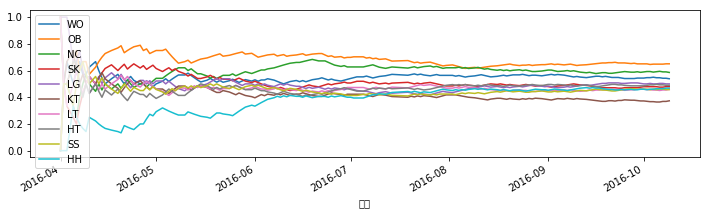

In [8]:
winplot(winrate_2016)

# 2017 일자별 승률 변화

In [9]:
winrate_2017

,일자,HH,HT,KT,LG,LT,NC,OB,SK,SS,WO
0,20170331,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
1,20170401,0.500000,1.000000,1.000000,1.000000,0.500000,0.500000,0.500000,0.000000,0.000000,0.000000
2,20170402,0.333333,0.666667,1.000000,1.000000,0.666667,0.333333,0.666667,0.000000,0.333333,0.000000
3,20170404,0.500000,0.750000,0.750000,1.000000,0.750000,0.250000,0.750000,0.000000,0.250000,0.000000
4,20170406,0.400000,0.800000,0.800000,1.000000,0.800000,0.400000,0.600000,0.000000,0.200000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
152,20170929,0.435714,0.607143,0.347518,0.492754,0.560284,0.557143,0.597122,0.517730,0.389706,0.492857
153,20170930,0.432624,0.607143,0.347518,0.496403,0.560284,0.560284,0.597122,0.521127,0.386861,0.489362
154,20171001,0.429577,0.602837,0.352113,0.492857,0.560284,0.560284,0.600000,0.521127,0.391304,0.489362
155,20171002,0.429577,0.605634,0.349650,0.492857,0.560284,0.560284,0.600000,0.521127,0.391304,0.489362


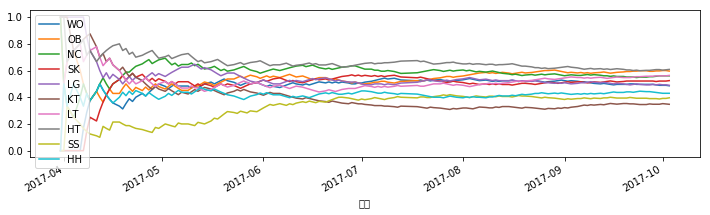

In [10]:
winplot(winrate_2017)

# 2018 일자별 승률 변화

In [11]:
winrate_2018

,일자,HH,HT,KT,LG,LT,NC,OB,SK,SS,WO
0,20180324,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
1,20180325,0.500000,0.500000,0.500000,0.000000,0.000000,1.000000,0.500000,1.000000,0.500000,0.500000
2,20180327,0.333333,0.666667,0.333333,0.000000,0.000000,1.000000,0.666667,1.000000,0.333333,0.666667
3,20180328,0.500000,0.500000,0.500000,0.250000,0.000000,0.750000,0.750000,0.750000,0.500000,0.500000
4,20180329,0.400000,0.600000,0.600000,0.200000,0.000000,0.800000,0.800000,0.600000,0.400000,0.600000
...,...,...,...,...,...,...,...,...,...,...,...
150,20181010,0.531469,0.492857,0.413043,0.471831,0.481752,0.411348,0.642857,0.550000,0.482014,0.521127
151,20181011,0.531469,0.489362,0.413043,0.471831,0.485507,0.411348,0.645390,0.546099,0.482014,0.521127
152,20181012,0.531469,0.492958,0.410072,0.471831,0.482014,0.408451,0.647887,0.546099,0.482014,0.524476
153,20181013,0.534722,0.489510,0.414286,0.475524,0.485714,0.405594,0.643357,0.542254,0.485714,0.520833


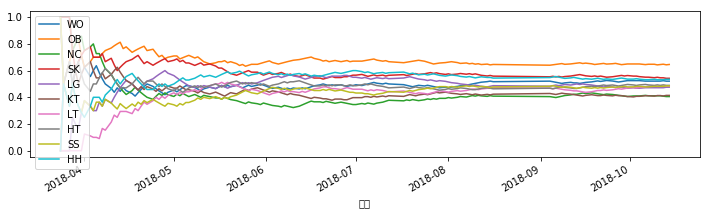

In [12]:
winplot(winrate_2018)

# 2019 일자별 승률 변화

In [13]:
winrate_2019

,일자,HH,HT,KT,LG,LT,NC,OB,SK,SS,WO
0,20190323,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000
1,20190324,0.500000,0.000000,0.000000,1.000000,0.500000,0.500000,0.500000,1.000000,0.500000,0.500000
2,20190326,0.666667,0.000000,0.000000,1.000000,0.666667,0.666667,0.666667,0.666667,0.333333,0.333333
3,20190327,0.500000,0.250000,0.000000,0.750000,0.500000,0.750000,0.750000,0.750000,0.500000,0.250000
4,20190328,0.400000,0.400000,0.000000,0.600000,0.400000,0.800000,0.600000,0.800000,0.600000,0.400000
...,...,...,...,...,...,...,...,...,...,...,...
155,20190927,0.411348,0.432624,0.492857,0.557143,0.347826,0.521429,0.604317,0.618705,0.418440,0.595745
156,20190928,0.408451,0.436620,0.496454,0.553191,0.347826,0.517730,0.607143,0.614286,0.422535,0.595745
157,20190929,0.405594,0.436620,0.500000,0.549296,0.345324,0.517730,0.609929,0.617021,0.419580,0.598592
158,20190930,0.402778,0.436620,0.500000,0.552448,0.342857,0.517730,0.609929,0.619718,0.419580,0.598592


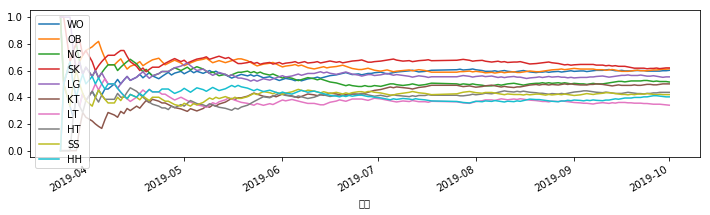

In [14]:
winplot(winrate_2019)

# 2020 일자별 승률 변화

In [15]:
winrate_2020

,일자,HH,HT,KT,LG,LT,NC,OB,SK,SS,WO
0,20200505,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
1,20200506,0.500000,0.000000,0.000000,0.500000,1.000000,1.000000,0.500000,0.500000,0.000000,1.000000
2,20200507,0.666667,0.333333,0.000000,0.333333,1.000000,1.000000,0.666667,0.333333,0.000000,0.666667
3,20200508,0.500000,0.250000,0.250000,0.250000,1.000000,1.000000,0.500000,0.250000,0.250000,0.750000
4,20200509,0.400000,0.200000,0.250000,0.250000,1.000000,1.000000,0.500000,0.250000,0.400000,0.800000
...,...,...,...,...,...,...,...,...,...,...,...
61,20200715,0.278689,0.551724,0.482759,0.517857,0.482759,0.684211,0.593220,0.305085,0.516667,0.600000
62,20200716,0.274194,0.542373,0.491525,0.508772,0.491525,0.689655,0.600000,0.300000,0.524590,0.590164
63,20200717,0.269841,0.550000,0.491525,0.517241,0.483333,0.689655,0.590164,0.311475,0.532258,0.580645
64,20200718,0.265625,0.540984,0.483333,0.525424,0.475410,0.694915,0.596774,0.306452,0.539683,0.587302


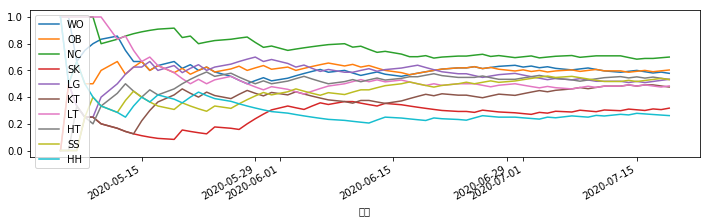

In [16]:
winplot(winrate_2020)